# Evaluating clustering with predictions
# Brendan Puglisi

## Preprocessing from previous NLP

In [125]:
import pandas as pd
import numpy as np #for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')#for model-building
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer#for word embedding
# Word2Vec (may deal with this later)
#! pip install gensim
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /Users/bpugs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/bpugs/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/bpugs/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/bpugs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [126]:
df = pd.read_csv('nrao_projects.csv')
df['target'] = pd.get_dummies(df['fs_type'], dtype=int)['line']
df['text'] = df.project_title + " " + df.project_abstract
df['text'] = df['text'].astype(str)
df_train = df[df['fs_type'] == 'line']


# combine low and high freq into a set under range column 

In [127]:
measurements = pd.read_csv('condensed_csv.csv')
measurements['range'] = measurements.apply(lambda row: (row['low_freq'], row['high_freq']), axis=1)


measurements = measurements.drop(['low_freq', 'high_freq'], axis = 1)
measurements =measurements.drop('Unnamed: 0' ,axis=1)

In [128]:
measurements.head()

,project_code,project_title,project_abstract,fs_type,target,range
0,2011.0.00010.S,NaN,NaN,NaN,NaN,"(87.47, 87.88)"
1,2011.0.00010.S,NaN,NaN,NaN,NaN,"(218.67, 220.46)"
2,2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,1.0,"(85.96, 86.19)"
3,2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,1.0,"(87.05, 87.29)"
4,2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,1.0,"(88.36, 88.59)"


# condense all project code rows, so range is a list of sets...

In [129]:
df = measurements.groupby('project_code')['range'].apply(list).reset_index()

In [130]:
first_occurrence = df.groupby('project_code', as_index=False).first()


result = pd.merge(first_occurrence, measurements, on='project_code')

# Drop extra rows and merge to get abstracts

In [131]:
result = result.drop('range_y', axis=1)

In [132]:
df_unique = df[~df.duplicated('project_code', keep=False)]

In [133]:
df_train = pd.merge(df_train, df_unique, on='project_code')

In [134]:
df_train

,project_code,project_title,project_abstract,fs_type,target,text,range
0,2018.1.01205.L,Fifty AU STudy of the chemistry in the disk/en...,The huge variety of planetary systems discover...,line,1,Fifty AU STudy of the chemistry in the disk/en...,"[(94.05, 95.95), (217.07, 217.14), (218.4, 218..."
1,2022.1.00316.L,COMPASS: Complex Organic Molecules in Protosta...,The emergence of complex organic molecules in ...,line,1,COMPASS: Complex Organic Molecules in Protosta...,"[(279.03, 311.75)]"
2,2017.1.00161.L,ALCHEMI: the ALMA Comprehensive High-resolutio...,A great variety in gas composition is observed...,line,1,ALCHEMI: the ALMA Comprehensive High-resolutio...,"[(84.1, 115.9), (125.02, 162.81), (211.05, 274..."
3,2021.1.01616.L,ALMA JELLY - Survey of Nearby Jellyfish and Ra...,We propose the first ever statistical survey o...,line,1,ALMA JELLY - Survey of Nearby Jellyfish and Ra...,"[(222.52, 228.07), (236.47, 242.25)]"
4,2021.1.00869.L,Bulge symmetry or not? The hidden dynamics of ...,A radio survey of red giant SiO sources in the...,line,1,Bulge symmetry or not? The hidden dynamics of ...,"[(84.1, 85.87), (87.02, 87.96), (86.08, 87.01)]"
...,...,...,...,...,...,...,...
3623,2022.1.01740.V,A detailed study of the sub-pc jet of BL Lacer...,AGN jets are key objects to broaden our knowle...,line,1,A detailed study of the sub-pc jet of BL Lacer...,"[(212.15, 214.02), (214.15, 216.02), (226.15, ..."
3624,2018.1.01465.V,Disorder vs. Order: Discerning the nature of t...,We propose using a combined ALMA+GMVA array to...,line,1,Disorder vs. Order: Discerning the nature of t...,"[(85.33, 87.19), (87.33, 89.19), (97.39, 99.25..."
3625,2021.1.00767.V,Ultra-high resolution imaging of 3C84,3C84 is a prime target for high angular resolu...,line,1,Ultra-high resolution imaging of 3C84 3C84 is ...,"[(212.19, 214.05), (214.19, 216.05), (226.19, ..."
3626,2019.1.00183.V,Imaging Jet and Magnetic Field near the Spinni...,Understanding the jet formation in supermassiv...,line,1,Imaging Jet and Magnetic Field near the Spinni...,"[(85.34, 87.21), (87.34, 89.21), (97.47, 99.33..."


# do all the same preprocesses

In [135]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text
 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [136]:
ps = nltk.PorterStemmer()
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
  
#lemmatization
df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train.head()

,project_code,project_title,project_abstract,fs_type,target,text,range,clean_text
0,2018.1.01205.L,Fifty AU STudy of the chemistry in the disk/en...,The huge variety of planetary systems discover...,line,1,Fifty AU STudy of the chemistry in the disk/en...,"[(94.05, 95.95), (217.07, 217.14), (218.4, 218...",fifty au study chemistry disk envelope system ...
1,2022.1.00316.L,COMPASS: Complex Organic Molecules in Protosta...,The emergence of complex organic molecules in ...,line,1,COMPASS: Complex Organic Molecules in Protosta...,"[(279.03, 311.75)]",compass complex organic molecule protostars al...
2,2017.1.00161.L,ALCHEMI: the ALMA Comprehensive High-resolutio...,A great variety in gas composition is observed...,line,1,ALCHEMI: the ALMA Comprehensive High-resolutio...,"[(84.1, 115.9), (125.02, 162.81), (211.05, 274...",alchemi alma comprehensive high resolution ext...
3,2021.1.01616.L,ALMA JELLY - Survey of Nearby Jellyfish and Ra...,We propose the first ever statistical survey o...,line,1,ALMA JELLY - Survey of Nearby Jellyfish and Ra...,"[(222.52, 228.07), (236.47, 242.25)]",alma jelly survey nearby jellyfish ram pressur...
4,2021.1.00869.L,Bulge symmetry or not? The hidden dynamics of ...,A radio survey of red giant SiO sources in the...,line,1,Bulge symmetry or not? The hidden dynamics of ...,"[(84.1, 85.87), (87.02, 87.96), (86.08, 87.01)]",bulge symmetry hidden dynamic far side radio s...


# Split into train and test before we word2vec

In [137]:
X_train, X_test= train_test_split(df_train,test_size=0.05,shuffle=True)

# fit tdidf to train, transform train and transform unseen test

In [138]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)

X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train['clean_text']) 

X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test['clean_text'])

#building Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
train_tok=[nltk.word_tokenize(i) for i in X_train['clean_text']]
test_tok=[nltk.word_tokenize(i) for i in X_test['clean_text']]

model = Word2Vec(train_tok,min_count=1) 
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors)) ## CHANGE model.wv._____

modelw = MeanEmbeddingVectorizer(w2v)

# converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(train_tok)
X_test_vectors_w2v = modelw.transform(test_tok) # CHANGE var name

# train model, lsa components = 20, clusters = variable

# Tune this, n_clusters, n_components, quantile, and tolerance

In [139]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD



ac = AgglomerativeClustering(n_clusters=200)
    
# Fit the model and predict clusters for lsa_matrix
lsa = TruncatedSVD(n_components = 20)

lsa_matrix = lsa.fit_transform(X_train_vectors_tfidf)
    
cluster_labels = ac.fit_predict(lsa_matrix)

# cant predict with heirarchical, so use kmeans to find similar ones (maybe kcop willl be better)

In [140]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(lsa_matrix, cluster_labels)

KNeighborsClassifier()

In [141]:
#transform data and fit it
lsa_matrix_test = lsa.fit_transform(X_test_vectors_tfidf)
test_clusters = knn.predict(lsa_matrix_test)

# add cluster id to dataframes

In [142]:
X_train['cluster'] = cluster_labels
X_test['cluster'] = test_clusters

# merge cluster number with the whole train dataset, get low_freq and high_freq to have a row each. Not be a list of sets

In [143]:
train_project_codes = X_train.project_code.to_list()

In [144]:
measurements = pd.read_csv('condensed_csv.csv')

filtered_df = measurements[measurements['project_code'].isin(train_project_codes)]
merged_df = pd.merge(filtered_df, X_train[['project_code', 'cluster']], on='project_code', how='left')
merged_df

,Unnamed: 0,project_code,project_title,project_abstract,fs_type,low_freq,high_freq,target,cluster
0,0,2011.0.00010.S,NaN,NaN,NaN,87.47,87.88,NaN,133
1,1,2011.0.00010.S,NaN,NaN,NaN,218.67,220.46,NaN,133
2,2,2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,85.96,86.19,1.0,133
3,3,2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,87.05,87.29,1.0,133
4,4,2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,88.36,88.59,1.0,133
...,...,...,...,...,...,...,...,...,...
15801,16609,2023.1.01720.S,The molecular ring orbiting Sgr A*: a small pr...,There is significant observational evidence po...,line,234.06,235.94,1.0,46
15802,16610,2023.1.01721.S,NaN,NaN,NaN,340.64,344.39,NaN,111
15803,16611,2023.1.01721.S,NaN,NaN,NaN,352.66,356.41,NaN,111
15804,16612,2023.A.00003.S,NaN,NaN,NaN,241.69,274.89,NaN,6


# Find common frequencies within clusters

In [358]:

# Adjusted function to check for frequency range overlaps within a tolerance of 5 units
def check_frequency_range_overlaps_with_tolerance(df, tolerance=0):
    # Dictionary to store the results
    results = {}
    
    # Iterate over each cluster
    for cluster, cluster_df in df.groupby('cluster'):
        # List to store tuples of (low_freq, high_freq, match_count)
        freq_ranges = []
        
        # Iterate over each project within the cluster
        projects = cluster_df['project_code'].unique()
        for project in projects:
            project_df = cluster_df[cluster_df['project_code'] == project]
            
            # Compare each frequency range against all other ranges in the cluster, excluding its own project
            for _, row in project_df.iterrows():
                # Expand the frequency range by the tolerance
                low_freq, high_freq = row['low_freq'] - tolerance, row['high_freq'] + tolerance
                
                # Count overlaps excluding the current project
                overlap_count = cluster_df[(cluster_df['project_code'] != project) &
                                           ((cluster_df['low_freq'] <= high_freq) & (cluster_df['high_freq'] >= low_freq))].project_code.unique().shape[0]
                
                    # Adjust the low_freq and high_freq back to their original values for reporting
                #low_freq, high_freq = row['low_freq'], row['high_freq']
                    # Record the frequency range and its overlap count
                freq_ranges.append((low_freq, high_freq, overlap_count))
        
        # Remove duplicates and sort
        unique_freq_ranges = sorted(set(freq_ranges), key=lambda x: (x[0], x[1]))
        
        # Only add to results if there are frequency ranges with overlaps
        if unique_freq_ranges:
            results[cluster] = unique_freq_ranges
    
    return results

# Apply the function to the entire DataFrame
frequency_range_overlaps_summary_with_tolerance = check_frequency_range_overlaps_with_tolerance(merged_df)

# Convert the summary to a DataFrame for easier visualization, if preferred
# Flatten the list of tuples for DataFrame conversion
summary_list = [{'cluster': cluster, 'low_freq': low_freq, 'high_freq': high_freq, 'overlap_count': count}
                for cluster, freq_ranges in frequency_range_overlaps_summary_with_tolerance.items()
                for low_freq, high_freq, count in freq_ranges]

summary_df = pd.DataFrame(summary_list)


In [359]:
summary_df

,cluster,low_freq,high_freq,overlap_count
0,0,86.30,86.36,0
1,0,86.72,86.78,2
2,0,86.75,86.88,2
3,0,86.76,86.88,2
4,0,87.06,87.12,0
...,...,...,...,...
14874,199,228.86,230.17,4
14875,199,228.99,229.49,4
14876,199,229.69,231.69,4
14877,199,242.61,247.21,1


# !!! these should match, but they don't w/ 2.5 tolerance. Change function to include boolean in project!=project line? !!!

In [382]:
len(merged_df.cluster.unique())


200

In [383]:
len(summary_df.cluster.unique())

200

In [380]:
#only keep frequencies that overlapped more than x times
#x = 1
#summary_df=summary_df[summary_df['overlap_count']>= x]

grouped_df = summary_df.groupby('cluster')

# Step 2: Calculate the median of 'overlap_count' column within each group
quartiles = grouped_df['overlap_count'].quantile(0.25)

# Step 3: Filter out rows that have overlap_count less than the median for their respective clusters
filtered_df = summary_df[summary_df.apply(lambda row: row['overlap_count'] >= quartiles[row['cluster']], axis=1)]

filtered_df = filtered_df[filtered_df.overlap_count != 0]

In [381]:
len(filtered_df.cluster.unique())

198

# confirm our results

In [279]:
sum_197 = filtered_df[filtered_df.cluster == 199]
sum_197[sum_197.low_freq ==111.54]

,cluster,low_freq,high_freq,overlap_count


In [250]:
len(merged_df[merged_df['cluster'] == 199].project_code.unique())


14

In [251]:
#range is (111.54	115.98) can be within 10 so really (101.54	125.98)
cluster197 = merged_df[merged_df['cluster'] == 199]
less_than_high = cluster197[cluster197.high_freq <= 125.98]
less_than_high[less_than_high.low_freq>=101.54]

#len(less_than_high[less_than_high.low_freq>=101.54].project_code.unique())

,Unnamed: 0,project_code,project_title,project_abstract,fs_type,low_freq,high_freq,target,cluster
2949,3112,2015.1.00591.S,NaN,NaN,NaN,113.19,115.74,NaN,199
5954,6227,2016.2.00195.S,NaN,NaN,NaN,110.26,115.13,NaN,199
11375,11932,2019.2.00052.S,NaN,NaN,NaN,111.54,115.98,NaN,199
11498,12056,2019.2.00139.S,NaN,NaN,NaN,113.66,115.68,NaN,199
11805,12370,2021.1.00199.S,NaN,NaN,NaN,111.58,115.98,NaN,199
13728,14445,2022.1.00343.S,NaN,NaN,NaN,111.09,115.93,NaN,199
15089,15862,2022.A.00032.S,NaN,NaN,NaN,111.83,115.57,NaN,199


# test the data

In [384]:
test_project_codes = X_test.project_code.to_list()
test_filtered_df = measurements[measurements['project_code'].isin(test_project_codes)]
test_merged_df = pd.merge(test_filtered_df, X_test[['project_code', 'cluster']], on='project_code', how='left')

In [385]:
test_merged_df

,Unnamed: 0,project_code,project_title,project_abstract,fs_type,low_freq,high_freq,target,cluster
0,34,2011.0.00039.S,NaN,NaN,NaN,338.32,342.06,NaN,25
1,35,2011.0.00039.S,NaN,NaN,NaN,350.37,354.08,NaN,25
2,42,2011.0.00061.S,NaN,NaN,NaN,96.08,100.25,NaN,21
3,43,2011.0.00061.S,NaN,NaN,NaN,108.12,111.29,NaN,21
4,44,2011.0.00061.S,NaN,NaN,NaN,327.33,331.57,NaN,21
...,...,...,...,...,...,...,...,...,...
803,16251,2023.1.00812.S,NaN,NaN,NaN,112.26,115.32,NaN,134
804,16503,2023.1.01382.S,NaN,NaN,NaN,186.85,190.63,NaN,86
805,16504,2023.1.01382.S,NaN,NaN,NaN,198.80,202.58,NaN,86
806,16586,2023.1.01660.S,NaN,NaN,NaN,85.55,89.38,NaN,80


In [386]:
import pandas as pd


def condense_overlaps(group):
    # Sort by low_freq for easier processing
    group = group.sort_values(by='low_freq').reset_index(drop=True)
    
    condensed_rows = []
    non_overlapping_rows = []
    
    i = 0
    while i < len(group):
        # Initialize with the current row's frequencies
        min_low = group.loc[i, 'low_freq']
        max_high = group.loc[i, 'high_freq']
        
        # Check for overlaps with subsequent rows
        j = i + 1
        while j < len(group) and group.loc[j, 'low_freq'] <= max_high:
            # Adjust the max_high if the current row's high_freq is greater
            max_high = max(max_high, group.loc[j, 'high_freq'])
            j += 1
        
        # If j has moved, there was an overlap
        if j > i + 1:
            condensed_rows.append({'cluster': group.loc[i, 'cluster'], 'low_freq': min_low, 'high_freq': max_high})
            i = j  # Skip past the condensed rows
        else:
            non_overlapping_rows.append(group.loc[i].to_dict())  # Keep row as is
            i += 1
    
    # Combine condensed and non-overlapping rows
    return pd.DataFrame(condensed_rows + non_overlapping_rows, columns=group.columns)

# Apply the function to each project_code group and concatenate the results
final_df = pd.concat([condense_overlaps(group) for _, group in filtered_df.groupby('cluster')], ignore_index=True)
final_df

,cluster,low_freq,high_freq,overlap_count
0,0.0,86.72,86.88,NaN
1,0.0,88.60,88.66,NaN
2,0.0,88.72,90.73,NaN
3,0.0,93.10,93.24,NaN
4,0.0,104.55,104.69,NaN
...,...,...,...,...
1876,199.0,99.05,103.30,NaN
1877,199.0,110.26,115.98,NaN
1878,199.0,214.88,220.07,NaN
1879,199.0,228.37,232.84,NaN


In [387]:
filtered_df[filtered_df.cluster==0].overlap_count.describe()

count    47.000000
mean      2.212766
std       1.267249
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       5.000000
Name: overlap_count, dtype: float64

In [388]:

def find_test_project_overlaps(test_df, summary_df, tolerance =0):
    # List to store the results
    overlap_results = []
    
    # Group the test set by project_code
    for project_code, group in test_df.groupby('project_code'):
        cluster = group['cluster'].iloc[0]  # Assuming all rows for a project have the same cluster
        
        # Retrieve the cluster frequencies from the summary_df
        cluster_freqs = summary_df[summary_df['cluster'] == cluster]
        
        # Compare each test frequency range against the cluster frequencies
        for _, test_row in group.iterrows():
            low_freq, high_freq = test_row['low_freq'] - tolerance, test_row['high_freq'] +tolerance
           
            # Check for overlaps
            overlaps = cluster_freqs[((cluster_freqs['low_freq'] <= high_freq) & (cluster_freqs['high_freq'] >= low_freq))]
            
            if not overlaps.empty:
                for _, overlap_row in overlaps.iterrows():
                    # Record each overlap
                    overlap_results.append({
                        'test_project_code': project_code,
                        'test_low_freq': low_freq,
                        'test_high_freq': high_freq,
                        'cluster': cluster,
                        'overlap_low_freq': overlap_row['low_freq'],
                        'overlap_high_freq': overlap_row['high_freq'],
                    })
    
    # Convert the results list to a DataFrame
    results_df = pd.DataFrame(overlap_results)
    
    return results_df

# Apply the function to compare the test set against the cluster frequencies
overlap_df = find_test_project_overlaps(test_merged_df, final_df)

In [389]:
#from test_cluster overlapping df, get the value counts for each project, showing how many overlapped for each project test project in predicted clust
compare = overlap_df.test_project_code.value_counts().to_frame().reset_index()
compare.rename(columns={'test_project_code': 'project_code', 'count': 'num_that_overlapped_btwn_test_and_clust'}, inplace=True)
compare1 = pd.merge(compare, X_test[['project_code', 'cluster']], on='project_code', how='right')

#from the cluster overlap dataframe, get value counts for each cluster, showing how many freq in each cluster 
cluster_counts = final_df.cluster.value_counts().to_frame().reset_index()
cluster_counts.rename(columns={'project_code': 'project_code', 'count': 'num_freq_in_cluster'}, inplace=True)
compare1 = pd.merge(compare1, cluster_counts, on='cluster', how='left')

#from test observation dataframe, get project code value_counts, showing how many frequencies in each test proj
num_of_freq_in_test =test_merged_df.project_code.value_counts().to_frame().reset_index()
num_of_freq_in_test.rename(columns={'project_code': 'project_code', 'count': 'num_freq_in_test_proj'}, inplace=True)
compare1 = pd.merge(compare1, num_of_freq_in_test, on='project_code', how='left')
compare1['num_that_overlapped_btwn_test_and_clust'] = compare1['num_that_overlapped_btwn_test_and_clust'].fillna(0)
compare1

,project_code,num_that_overlapped_btwn_test_and_clust,cluster,num_freq_in_cluster,num_freq_in_test_proj
0,2019.2.00227.S,1.0,106,9,2
1,2023.1.01660.S,1.0,80,7,2
2,2021.1.00473.S,7.0,74,15,16
3,2017.1.00994.S,0.0,183,9,2
4,2019.1.00951.S,6.0,166,9,5
...,...,...,...,...,...
177,2019.1.00216.S,5.0,67,18,9
178,2021.A.00023.S,1.0,30,10,1
179,2016.1.00954.S,1.0,14,15,4
180,2022.1.00873.V,4.0,6,5,4


In [390]:
compare1.num_freq_in_cluster.value_counts()

num_freq_in_cluster
10    20
8     19
3     19
15    13
5     13
6     12
18    11
20    10
11     9
7      9
16     8
12     8
17     5
9      5
39     5
13     3
31     3
21     2
4      2
2      1
28     1
14     1
1      1
23     1
24     1
Name: count, dtype: int64

In [391]:
import pandas as pd



# Function to return rows where one column is larger than the other
def rows_with_larger_column(df, column1, column2):
    return df[df[column1] > df[column2]]

# Call the function with column names
result_df = rows_with_larger_column(compare1, 'num_that_overlapped_btwn_test_and_clust', 'num_freq_in_test_proj')
result_df



,project_code,num_that_overlapped_btwn_test_and_clust,cluster,num_freq_in_cluster,num_freq_in_test_proj
4,2019.1.00951.S,6.0,166,9,5
9,2021.2.00096.S,5.0,171,39,4
26,2013.1.01057.S,11.0,46,18,5
38,2011.0.00510.S,9.0,171,39,5
44,2021.1.01047.S,5.0,17,20,4
54,2019.A.00017.S,3.0,123,11,2
81,2022.1.00917.S,5.0,126,16,4
83,2019.1.00949.S,7.0,124,8,5
91,2013.1.01064.S,2.0,84,8,1
104,2013.1.00991.S,4.0,88,6,3


<Axes: >

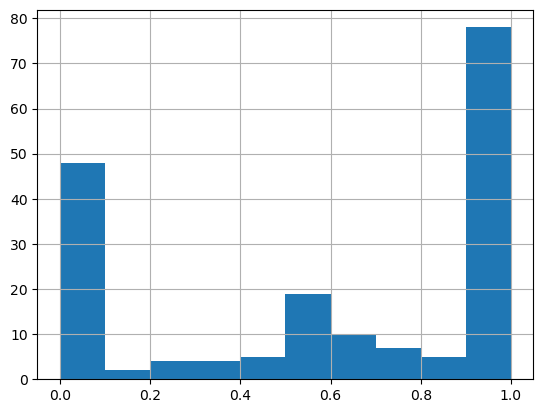

In [392]:
#compare1['metric'] = compare1['num_that_overlapped_btwn_test_and_clust'] / (compare1['num_freq_in_cluster'] * compare1['num_freq_in_test_proj'])
compare1['metric'] = compare1['num_that_overlapped_btwn_test_and_clust'] /  compare1['num_freq_in_test_proj']
compare1['metric'] = compare1['metric'].apply(lambda x: 1 if x > 1 else x)
compare1.metric.hist()

In [393]:
compare1.metric.mean()

0.5934972327799609

In [394]:
print('got ' + str(len(overlap_df.test_project_code.unique())) + ' out of '+ str(len(test_merged_df.project_code.unique())))

got 135 out of 182


# need to find balance between metric mean and percentage above, this will be tricky.